In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn import svm
from keras.datasets import imdb

2023-06-14 15:59:18.272498: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 15:59:18.520965: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-14 15:59:18.522463: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 15:59:19.886936: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load the dataset

In [2]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    path="imdb.npz",
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=start_char,
    oov_char=oov_char,
    index_from=index_from,
)

print(x_train.shape, x_test.shape)

# Retrieve the word index file mapping words to indices
word_index = imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[2])
decoded_sequence

(25000,) (25000,)


"[START] this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had earnt working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how embarrasing this is to watch save yourself an hour a bit of your life"

In [7]:
flat_array = np.concatenate(x_train)

# Count the frequencies of each integer
unique_values, value_counts = np.unique(flat_array, return_counts=True)

# Sort the integers based on their frequencies in descending order
sorted_indices = np.argsort(value_counts)[::-1]

# Retrieve the integers with the highest frequencies
most_frequent_integers = unique_values[sorted_indices]

print(most_frequent_integers[0:10])
# Print the words corresponding to the most frequent integers
for i in most_frequent_integers[0:10]:
  print(inverted_word_index[i])

[ 4  5  6  7  8  9 10 11 12 13]
the
and
a
of
to
is
br
in
it
i


In [3]:
shorter_word_by_indices = {}
vocab_size = 30000
# inverted_word_index[4]
for i in range(4,vocab_size + 4):
  shorter_word_by_indices[i-4] = inverted_word_index[i]
len(shorter_word_by_indices)

30000

In [4]:
word_index["[START]"] = 1
word_index["[OOV]"] = 2

In [5]:
def extract_bow_feature_vectors(reviews, word_by_indices, binarize=False):
    """
    Args:
        `reviews` - a list of natural language strings
        `indices_by_word` - a dictionary of uniquely-indexed words.
    Returns:
        a matrix representing each review via bag-of-words features.  This
        matrix thus has shape (n, m), where n counts reviews and m counts words
        in the dictionary.
    """

    feature_matrix = np.zeros([len(reviews), len(word_by_indices)], dtype=np.float64)
    for i, word_indices in enumerate(reviews):
        for word_index in word_indices:
            # word = word_by_indices[word_index]
            if word_index not in word_by_indices : continue
            elif binarize:
                feature_matrix[i, word_index] = 1
            elif not binarize:
                feature_matrix[i, word_index] += 1
    print(feature_matrix[1][1:10])
    return feature_matrix   


In [6]:
train_size = 18000
test_size = 2000
feature_matrix_train = extract_bow_feature_vectors(x_train[:train_size], shorter_word_by_indices)
feature_matrix_test = extract_bow_feature_vectors(x_test[:test_size], shorter_word_by_indices)

[ 1.  0.  0. 15. 10.  3.  2.  3. 10.]
[ 1.  0.  0. 18.  9.  6.  7.  6.  7.]


## SVM

In [ ]:
classifier = svm.SVC(kernel='rbf')
classifier.fit(feature_matrix_train, y_train[:10000])

In [ ]:
y_pred = classifier.predict(feature_matrix_test[:10])
np.mean(np.equal(y_pred, y_test[:10]))

## NN

In [7]:
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn

In [8]:
def batchify_data(x_data, y_data, batch_size):
    """Takes a set of data points and labels and groups them into batches."""
    # Only take batch_size chunks (i.e. drop the remainder)
    N = int(len(x_data) / batch_size) * batch_size
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(x_data[i:i+batch_size], dtype = torch.float),
            'y': torch.tensor(y_data[i:i+batch_size], dtype = torch.long)})
    return batches

def compute_accuracy(predictions, y):
    """Computes the accuracy of predictions against the gold labels, y."""
    return np.mean(np.equal(predictions.numpy(), y.numpy()))

In [9]:
def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in data:#tqdm(data):
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions
        out = model(x)

        # Predict and store accuracy
        predictions = torch.argmax(out, dim=1)
        batch_accuracies.append(compute_accuracy(predictions, y))

        # Compute loss
        loss = F.cross_entropy(out, y) + 0.1*sum(torch.norm(p) for p in model.parameters())
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

In [10]:
def train_model(train_data, dev_data, model, lr=0.1, momentum=0.1, nesterov=False, n_epochs=30):
    """Train a model for N epochs given data and hyper-params."""
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    epochs_i = []
    losses_i = []
    val_losses_i = []
    val_accs_i = []

    for epoch in range(1, n_epochs+1):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        loss, acc = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))
        losses_i.append(loss)
        epochs_i.append(epoch)
        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer)
        val_losses_i.append(val_loss)
        val_accs_i.append(val_acc)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        # Save model
        torch.save(model, "/notebooks/Sentiment_analysis_IMDB.pt")
    return losses_i, val_losses_i, val_accs_i, epochs_i

In [11]:
# create batches for SGD
batch_size = 32
train_batches = batchify_data(feature_matrix_train, y_train[:train_size], batch_size)
test_batches = batchify_data(feature_matrix_test, y_test[:test_size], batch_size)

In [12]:
feature_matrix_train.shape, train_batches[0]["x"].shape, train_batches[0]["y"].shape, len(train_batches), 

((18000, 30000), torch.Size([32, 30000]), torch.Size([32]), 562)

In [13]:
#################################
## Model specification TODO
model = nn.Sequential(
          nn.Linear(feature_matrix_test.shape[1], 128),
          nn.Tanh(),
          nn.Linear(128, 128),
          nn.Tanh(),
          nn.Linear(128, 128),
          nn.Tanh(),
          nn.Linear(128, 2)
        )
##################################
model

Sequential(
  (0): Linear(in_features=30000, out_features=128, bias=True)
  (1): Tanh()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Tanh()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): Tanh()
  (6): Linear(in_features=128, out_features=2, bias=True)
)

In [14]:
# train the model
losses_i, val_losses_i, val_accs, epochs_i = train_model(train_batches, test_batches, model, lr=0.001, momentum = 0.9, nesterov=True, n_epochs = 20)

# # Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:

Train loss: 2.646825 | Train accuracy: 0.657807
Val loss:   2.422803 | Val accuracy:   0.757056
-------------
Epoch 2:

Train loss: 2.284120 | Train accuracy: 0.787867
Val loss:   2.144870 | Val accuracy:   0.822581
-------------
Epoch 3:

Train loss: 2.044735 | Train accuracy: 0.841137
Val loss:   1.947341 | Val accuracy:   0.854839
-------------
Epoch 4:

Train loss: 1.857187 | Train accuracy: 0.865825
Val loss:   1.783581 | Val accuracy:   0.862399
-------------
Epoch 5:

Train loss: 1.691185 | Train accuracy: 0.880894
Val loss:   1.635306 | Val accuracy:   0.877016
-------------
Epoch 6:

Train loss: 1.540038 | Train accuracy: 0.891014
Val loss:   1.499384 | Val accuracy:   0.875504
-------------
Epoch 7:

Train loss: 1.401845 | Train accuracy: 0.897520
Val loss:   1.374946 | Val accuracy:   0.875000
-------------
Epoch 8:

Train loss: 1.276816 | Train accuracy: 0.902358
Val loss:   1.262328 | Val accuracy:   0.877520
-------------
Epoch 9:

Train loss: 1.16

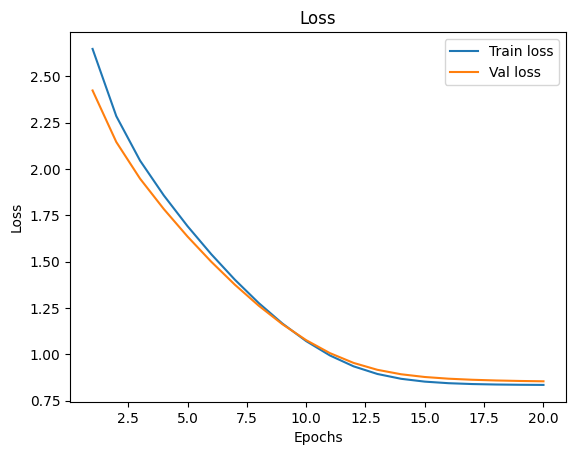

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(epochs_i, losses_i, label = "Train loss")
plt.plot(epochs_i, val_losses_i, label = "Val loss")
plt.legend()
plt.show()

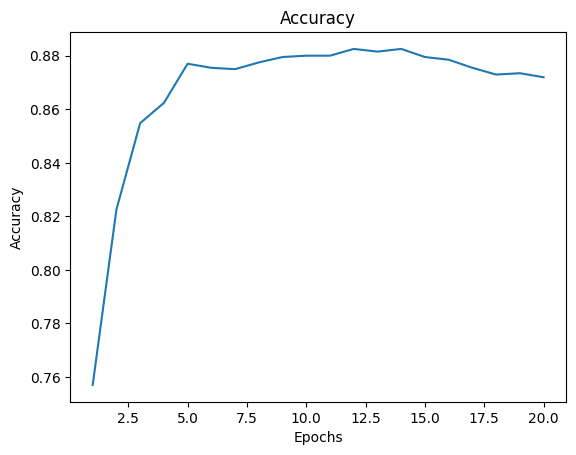

In [16]:
plt.figure()
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(epochs_i, val_accs)
plt.show()

In [89]:
stepi = []
lossi = []

In [90]:
import random
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

for i in range(100):
  # minibatch construct
  # forward pass
  ix = random.randint(0,len(train_batches)-1)
  out = model(train_batches[ix]['x'])
  # print(out.shape)
  loss = F.cross_entropy(out, train_batches[ix]['y']) #+ sum(torch.norm(p) for p in model.parameters())
  
  #update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # scheduler.step()

  stepi.append(i)
  lossi.append(loss.log10().data.item())

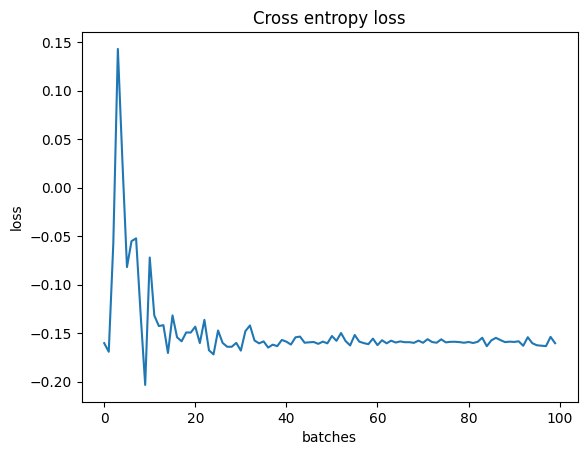

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Cross entropy loss")
plt.ylabel("loss")
plt.xlabel("batches")
plt.plot(stepi, lossi)

In [152]:
x_train_vocab = []
x_test_vocab = []
for i in range(0,train_size):
  x_train_npi = np.array(x_train[i])
  mask = x_train_npi <= 20000
  x_train_vocab.append(x_train_npi[mask])

for i in range(0,test_size):
  x_test_npi = np.array(x_train[i])
  mask = x_test_npi <= 20000
  x_test_vocab.append(x_test_npi[mask])
x_train_vocab[1]

array([    1,   194,  1153,   194,  8255,    78,   228,     5,     6,
        1463,  4369,  5012,   134,    26,     4,   715,     8,   118,
        1634,    14,   394,    20,    13,   119,   954,   189,   102,
           5,   207,   110,  3103,    21,    14,    69,   188,     8,
          30,    23,     7,     4,   249,   126,    93,     4,   114,
           9,  2300,  1523,     5,   647,     4,   116,     9,    35,
        8163,     4,   229,     9,   340,  1322,     4,   118,     9,
           4,   130,  4901,    19,     4,  1002,     5,    89,    29,
         952,    46,    37,     4,   455,     9,    45,    43,    38,
        1543,  1905,   398,     4,  1649,    26,  6853,     5,   163,
          11,  3215, 10156,     4,  1153,     9,   194,   775,     7,
        8255, 11596,   349,  2637,   148,   605, 15358,  8003,    15,
         123,   125,    68,  6853,    15,   349,   165,  4362,    98,
           5,     4,   228,     9,    43,  1157,    15,   299,   120,
           5,   120,

In [153]:
max_length=1000

x_train_subset = np.zeros((train_size, max_length), dtype=int)
x_test_subset = np.zeros((test_size, max_length), dtype=int)

for i in range(0, train_size):
  if(len(x_train_vocab[i]) < max_length):
    x_train_subset[i] = np.pad(x_train_vocab[i], (0, max_length - len(x_train_vocab[i])), mode="constant", constant_values = 0)
  else:
    x_train_subset[i] = x_train_vocab[i][:max_length]

for i in range(0, test_size):
  if(len(x_test_vocab[i]) < max_length):
    x_test_subset[i] = np.pad(x_test_vocab[i], (0, max_length - len(x_test_vocab[i])), mode="constant", constant_values = 0)
  else:
    x_test_subset[i] = x_test_vocab[i][:max_length]

y_train_subset = y_train[:train_size]
y_test_subset = y_test[:test_size]
x_train_subset.shape

(18000, 1000)

In [95]:
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train_subset[1])
decoded_sequence

"[START] big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is completely laughable the best is the end showdown with the cop and how he worked out who the killer is it's just so damn terribly written the clothes are sickening and funny in equal measures the hair is big lots of boobs bounce men wear those cut tee shirts that show off their sickening that men actually wore them and the music is just trash that plays over and over again in almost every scene there is trashy music boobs and taking away bodies and the gym still doesn't close for all joking aside this is a truly bad film whose only charm is to look back on the disaster that was the 80's and have a good old laugh at how bad everything was back then [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OOV] [OO

In [162]:
# create batches for SGD
batch_size = 32
train_batches = batchify_data(x_train_subset, y_train[:train_size], batch_size)
test_batches = batchify_data(feature_matrix_test, y_test[:test_size], batch_size)

In [17]:
embedding_dim = 30
vocab_size = 20001
#################################
# Model specification TODO
model = nn.Sequential(
          nn.Embedding(vocab_size, embedding_dim, padding_idx = 0),
          nn.Flatten(),
          nn.Linear(max_length * embedding_dim, 128),
          nn.Tanh(),
          nn.Linear(128, 256),
          nn.Tanh(),
          nn.Linear(256, 256),
          nn.Tanh(),
          nn.Linear(256, 2)
        )

NameError: name 'max_length' is not defined

In [167]:
# train the model
losses_i, val_losses_i, val_accs, epochs_i = train_model(train_batches, test_batches, model, lr=0.001, momentum = 0.9, nesterov=True, n_epochs = 10)

# # Evaluate the model on test data
loss, accuracy = run_epoch(test_batches, model.eval(), None)

print ("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))

-------------
Epoch 1:



100%|██████████| 562/562 [00:12<00:00, 46.01it/s]


Train loss: 47.985553 | Train accuracy: 0.518961


100%|██████████| 31/31 [00:00<00:00, 250.84it/s]


Val loss:   47.790327 | Val accuracy:   0.492944
-------------
Epoch 2:



100%|██████████| 562/562 [00:11<00:00, 46.90it/s]


Train loss: 47.636886 | Train accuracy: 0.561277


100%|██████████| 31/31 [00:00<00:00, 263.11it/s]


Val loss:   47.511433 | Val accuracy:   0.525202
-------------
Epoch 3:



100%|██████████| 562/562 [00:11<00:00, 47.54it/s]


Train loss: 47.399271 | Train accuracy: 0.504504


100%|██████████| 31/31 [00:00<00:00, 258.79it/s]


Val loss:   47.286649 | Val accuracy:   0.525202
-------------
Epoch 4:



100%|██████████| 562/562 [00:11<00:00, 48.13it/s]


Train loss: 47.174459 | Train accuracy: 0.501001


100%|██████████| 31/31 [00:00<00:00, 240.38it/s]


Val loss:   47.061878 | Val accuracy:   0.525202
-------------
Epoch 5:



 68%|██████▊   | 381/562 [00:08<00:03, 46.33it/s]


KeyboardInterrupt: ignored

In [149]:
stepi = []
lossi = []

In [150]:
import random
lr = 0.001
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)

for i in range(10000):
  # minibatch construct
  # forward pass
  ix = []
  for j in range(32):
    ix.append(random.randint(0,len(x_train_subset)-1))

  out = model(torch.tensor(x_train_subset[[ix]]))
  # print(out.shape)
  loss = F.cross_entropy(out, torch.tensor(y_train_subset[[ix]])) #+ sum(torch.norm(p) for p in model.parameters())
  
  #update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # scheduler.step()

  stepi.append(i)
  lossi.append(loss.log10().data.item())

<ipython-input-150-b7012c53f968>:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = model(torch.tensor(x_train_subset[[ix]]))
<ipython-input-150-b7012c53f968>:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  loss = F.cross_entropy(out, torch.tensor(y_train_subset[[ix]])) #+ sum(torch.norm(p) for p in model.parameters())


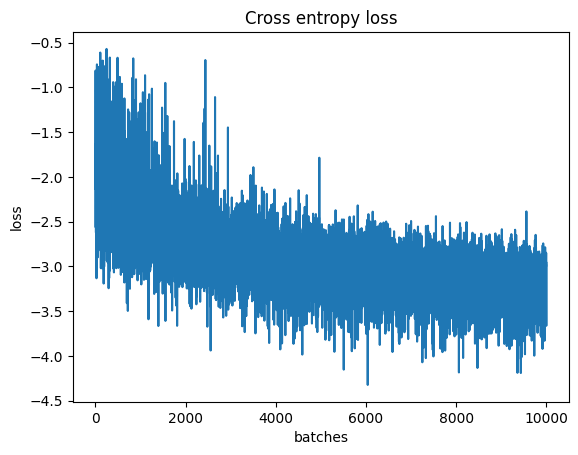

In [151]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.title("Cross entropy loss")
plt.ylabel("loss")
plt.xlabel("batches")
plt.plot(stepi, lossi)